# Random Forest( Trend Forcasting)

[*********************100%***********************]  1 of 1 completed
              precision    recall  f1-score   support

         0.0       0.85      0.77      0.81       878
         1.0       0.86      0.91      0.88      1340

    accuracy                           0.86      2218
   macro avg       0.85      0.84      0.85      2218
weighted avg       0.86      0.86      0.85      2218



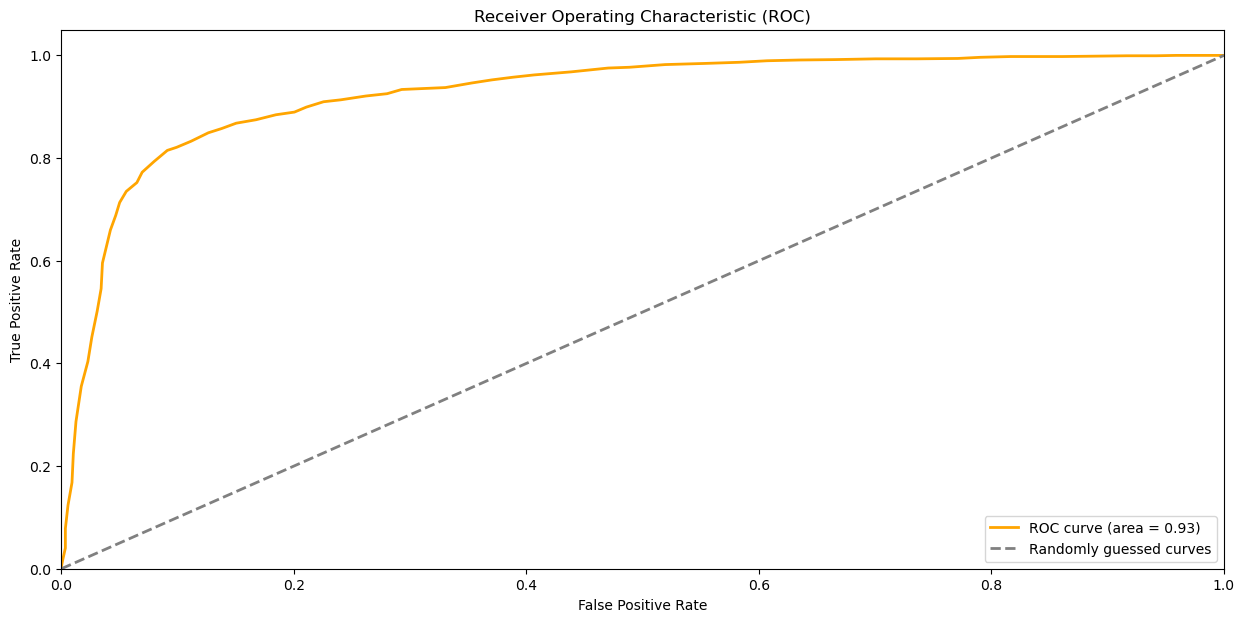

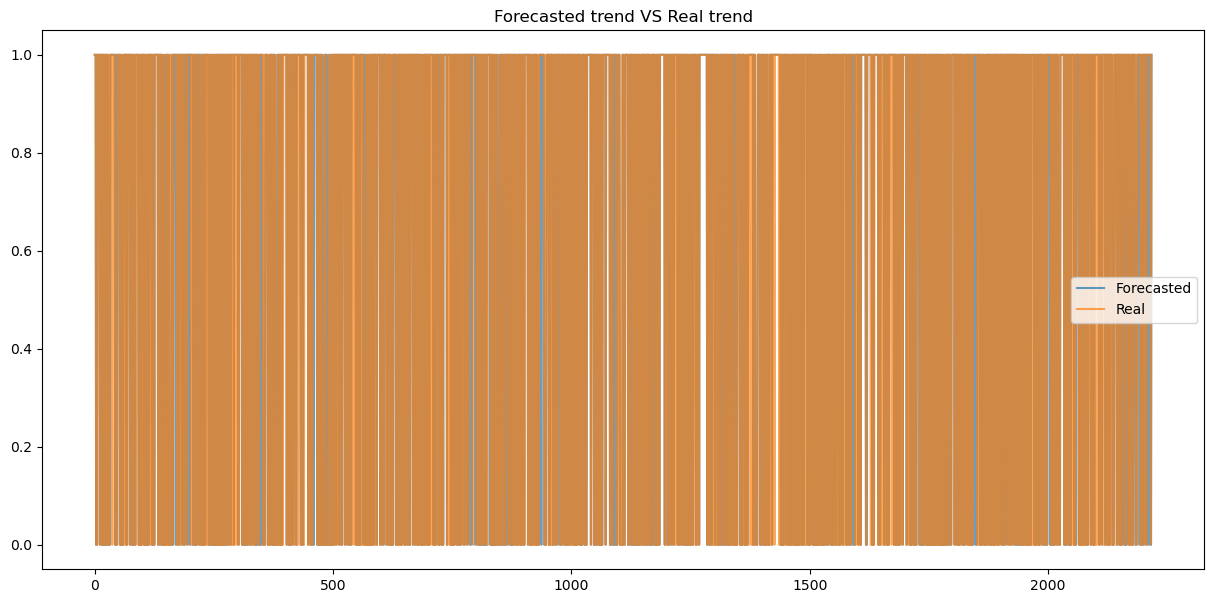

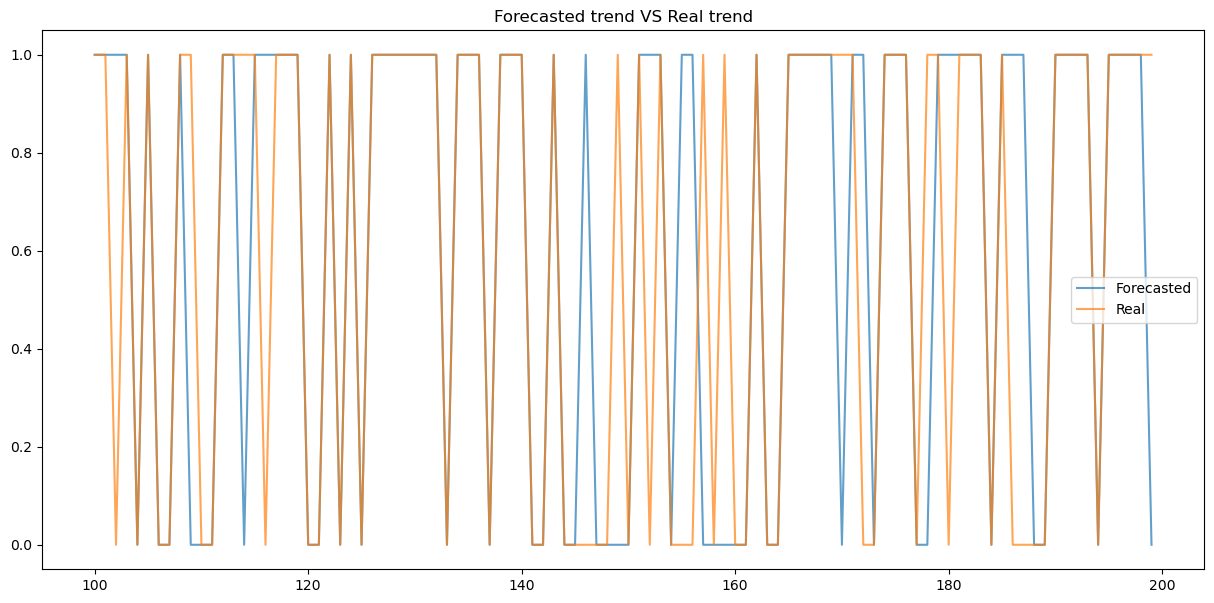

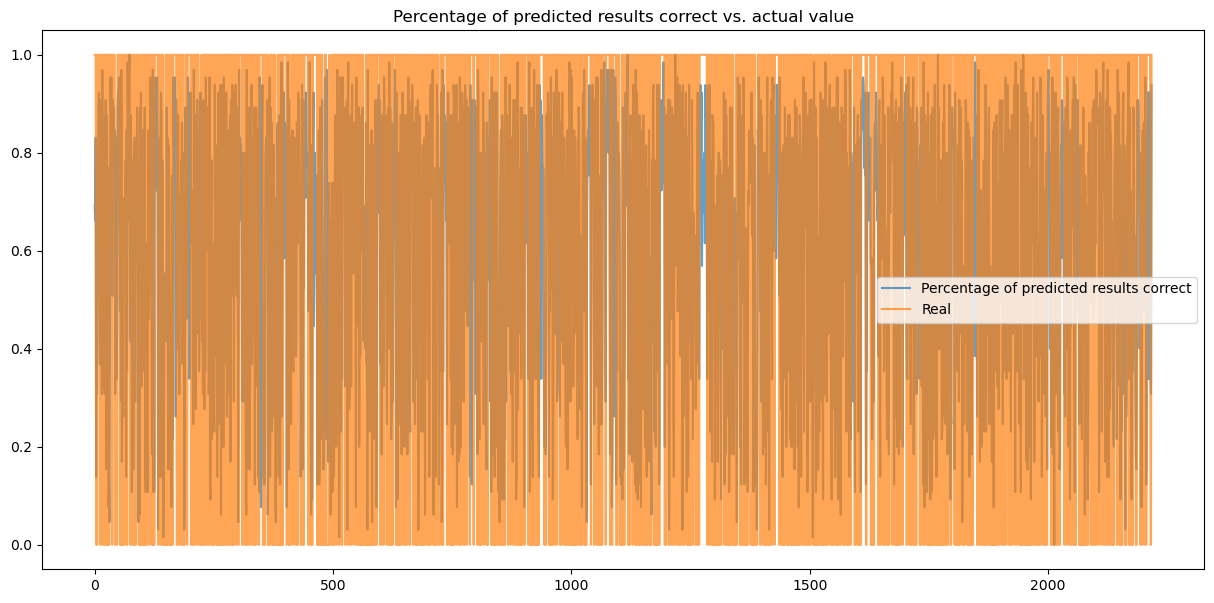

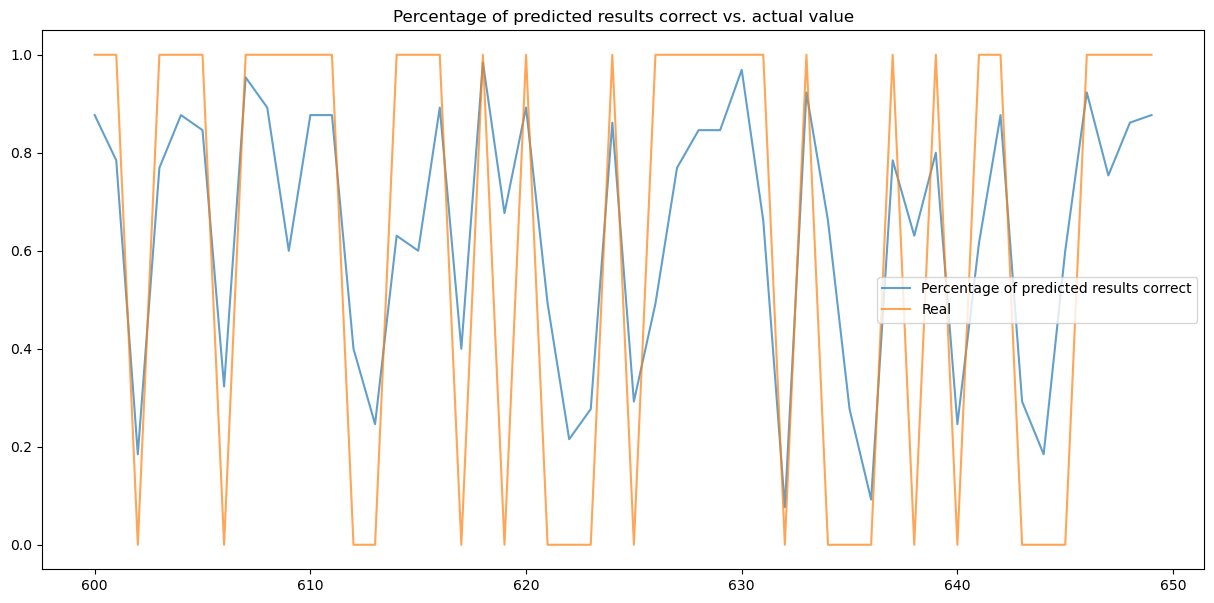

It'll go up tomorrow


In [6]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import talib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import yfinance as yf
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

np.random.seed(5)
random.seed(5)

#Smoothing index weighting，Call ewm to implement，Increase temporal relevance and reduce fallout
def expProcessing(df,alpha=0.9):
    data = df.ewm(alpha=alpha).mean()
    return data

# calculate technical analysis indicators and add to data
def featureExtensions(data):
    for x in [9, 14, 21, 30, 50, 90]:
        # Calculate RSI (Relative Strength Index)
        data['RSI_' + str(x)] = talib.RSI(data['Close'], timeperiod=x)
        # Calculate ROC (Rate of Change)
        data['ROC_' + str(x)] = talib.ROC(data['Close'], timeperiod=x)
        # Calculate Stochastic oscillator %D
        slowk, slowd = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=x, slowk_period=x,
                                   slowd_period=x)
        data['STOCH_SlowK_' + str(x)] = slowk
        data['STOCH_SlowD_' + str(x)] = slowd
        # Accumulation/Distribution
        data['ACCDIST_' + str(x)] = talib.AD(data['High'], data['Low'], data['Close'], data['Volume'])
        # On-balance Volume
        data['OBV_' + str(x)] = talib.OBV(data['Close'], data['Volume'])
        # Commodity Channel Index
        data['CCI_' + str(x)] = talib.CCI(data['High'], data['Low'], data['Close'], timeperiod=x)
        # Ease of Movement
        prev_high = data['High'].shift(1)
        prev_low = data['Low'].shift(1)
        eom = ((data['High'] + data['Low']) / 2 - (prev_high + prev_low) / 2) / (data['High'] - data['Low']) * data[
            'Volume']
        data['EOM_' + str(x)] = eom
        # Trix
        data['TRIX_' + str(x)] = talib.TRIX(data['Close'], timeperiod=x)
        #         # Vortex Indicator
        #         data['Vortex_' + str(x)] = talib.VortexIndicator(data['High'], data['Low'], data['Close/Last'], timeperiod=x)
        # Momentum
        data['MOM_' + str(x)] = talib.MOM(data['Close'], timeperiod=x)
        # oney Flow Index and Ratio
        data['MFI_' + str(x)] = talib.MFI(data['High'], data['Low'], data['Close'], data['Volume'], timeperiod=x)

    # add MACD to data
    macd, signal, _ = talib.MACD(data['Close'], fastperiod=14, slowperiod=50, signalperiod=9)
    data['MACD'] = macd
    data['MACD_Signal'] = signal

    # Add n-day exponential moving average to the data
    for x in [9, 14, 21, 30, 50]:
        ema = talib.EMA(data['Close'], timeperiod=x)
        data['EMA_' + str(x)] = ema

    return data

    del (data['Volume'])
    del (data['Open'])
    del (data['High'])
    del (data['Low'])

    return data

#predict
def predict(df,n):
    pred = (df.shift(-n)['Close'].values >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)

# add pretiction column to data
def dataProcessing(df,horizon):
    data = featureExtensions(df).dropna().iloc[:-horizon]
    data['pred']= predict(data,n=horizon)
    # delete the close price to preventing predicted values from tracking to it
    del(data['Close'])
    return data.dropna()

SPLIT_RATIO = 0.7 # another option is 2/3
spy_data = yf.download('SPY', start='1993-01-29', end='2023-08-01')
data = spy_data.shift().dropna() #delete NAN
data = data.reset_index(drop=True)
del(data['Adj Close'])

#data added Smoothing index weighting
s_data = expProcessing(data)
dataset = dataProcessing(s_data,10)

x = dataset[[x for x in dataset.columns if x not in ['pred']]]
y = dataset['pred']

x_train, x_test,y_train, y_test = train_test_split(x,y,train_size=SPLIT_RATIO,random_state=5)
pipe = RandomForestClassifier(n_jobs=-1, n_estimators=65,random_state=5)
pipe.fit(x_train,y_train.values.ravel())

prediction = pipe.predict(x_test)
report = classification_report(y_test,prediction)
print(report)

# Probability values predicted by the model
probs = pipe.predict_proba(x_test)[:, 1]

# Calculate the points of the ROC curve
fpr, tpr, _ = roc_curve(y_test, probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(15, 7))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, label='Randomly guessed curves',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
plt.figure(figsize=(15,7))
plt.title('Forecasted trend VS Real trend')
plt.plot(np.arange(len(prediction)),prediction,alpha=0.7,label='Forecasted')
plt.plot(np.arange(len(y_test)),y_test,alpha=0.7,label='Real')
plt.legend()
plt.show()

plt.figure(figsize=(15, 7))
plt.title('Forecasted trend VS Real trend')

# Select a specific range of values to compare
start_index = 100  # Adjust the start index as needed
end_index = 200    # Adjust the end index as needed

plt.plot(np.arange(start_index, end_index), prediction[start_index:end_index], alpha=0.7, label='Forecasted')
plt.plot(np.arange(start_index, end_index), y_test[start_index:end_index], alpha=0.7, label='Real')

plt.legend()
plt.show()

# chance of comparison
plt.figure(figsize=(15,7))
posibility = Model.predict_proba(x_test)[:,1]
plt.title('Percentage of predicted results correct vs. actual value')
plt.plot(np.arange(len(posibility)),posibility,alpha=0.7,label='Percentage of predicted results correct')
plt.plot(np.arange(len(y_test)),y_test,alpha=0.7,label='Real')

plt.legend()
plt.show()

# Select a specific range of values to compare
plt.figure(figsize=(15,7))
posibility = Model.predict_proba(x_test)[:,1]
plt.title('Percentage of predicted results correct vs. actual value')

start_index = 600  # Adjust the start index as needed
end_index = 650    # Adjust the end index as needed

plt.plot(np.arange(start_index, end_index), posibility[start_index:end_index], alpha=0.7, label='Percentage of predicted results correct')
plt.plot(np.arange(start_index, end_index), y_test[start_index:end_index], alpha=0.7, label='Real')

plt.legend()
plt.show()

### predict tomorrow's stock trend (0 or 1)
t = prediction[-1]
if t == 1:
    print("It'll go up tomorrow")
else:
    print("TIt's going down tomorrow")

# LSTM (Price Forcasting)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


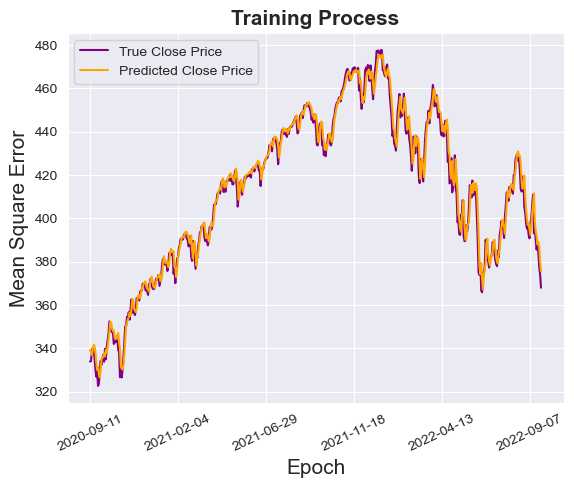

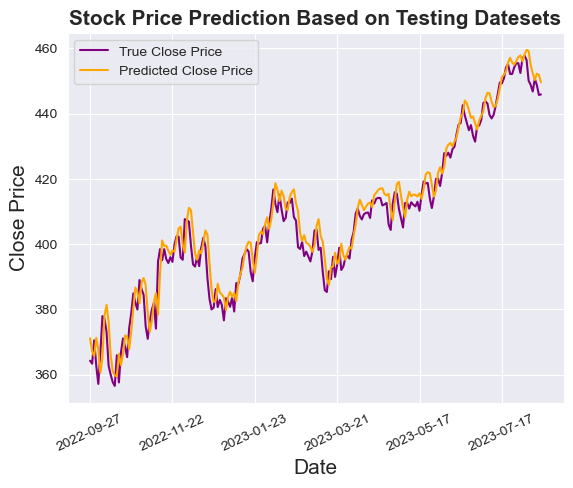

Tomorrow's price will be 448.5714


In [2]:
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import copy



def dataset_generation_for_LSTM(Close_data, Impact_length):
    data_length = len(Close_data.values)
    selected_data = Close_data.values
    temp = []

    for i in range(data_length - Impact_length):
        temp.append(selected_data[i:i + Impact_length])

    temp = np.array(temp).reshape(data_length - Impact_length, Impact_length, 1)
    test_size_shape = int(np.round(0.3 * temp.shape[0]))
    train_size_shape = temp.shape[0] - test_size_shape

    data_train, data_test, Target_train, Target_test = temp[:train_size_shape, :-1], temp[train_size_shape:, :-1],\
                                                       temp[:train_size_shape, -1], temp[train_size_shape:, -1]

    return data_train, data_test, Target_train, Target_test


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layer = num_layer

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layer, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layer, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layer, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc1(out[:, -1, :])
        return out


### Data preparation and preprocessing
Original_data = yf.download('SPY', period='5y')

Start_date = '2020-7-1'
Impact_length = 50

scaler = MinMaxScaler(feature_range=(-1, 1))
Original_data['Close'] = scaler.fit_transform(Original_data['Close'].values.reshape(-1, 1))

Close_data = Original_data.Close.loc[Start_date:]

data_train, data_test, Target_train, Target_test = dataset_generation_for_LSTM(Close_data, Impact_length)

data_test_copy = copy.deepcopy(data_test)

data_train = torch.from_numpy(data_train).type(torch.Tensor)
data_test = torch.from_numpy(data_test).type(torch.Tensor)
Target_train = torch.from_numpy(Target_train).type(torch.Tensor)
Target_test = torch.from_numpy(Target_test).type(torch.Tensor)

input_dim = data_train.shape[2]
hidden_dim = 8
num_layer = 2
output_dim = 1
num_epochs = 200

model = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, num_layer = num_layer, output_dim = output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

record = np.zeros(num_epochs)

for i in range(num_epochs):
    Target_train_prediction = model(data_train)
    loss = criterion(Target_train_prediction, Target_train)
#     print('Epoch=', i, 'MSE=', loss.item())
    record[i] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

predict_price_trainset = pd.DataFrame(scaler.inverse_transform(Target_train_prediction.detach().numpy()))
True_price_trainset = pd.DataFrame(scaler.inverse_transform(Target_train.detach().numpy()))

data_for_comparison = yf.download('SPY', period='5y')
data_new_train = data_for_comparison['Close'].loc[Start_date:].iloc[Impact_length:data_train.shape[0]+Impact_length]
data_new_test = data_for_comparison['Close'].loc[Start_date:].iloc[data_train.shape[0]+Impact_length:]

sns.set_style('darkgrid')

F = plt.figure()

lh = sns.lineplot(x = True_price_trainset.index, y = True_price_trainset[0], label = 'True Close Price', color = 'purple')
lh = sns.lineplot(x = predict_price_trainset.index, y = predict_price_trainset[0], label = 'Predicted Close Price', color = 'orange')
lh.set_title('Stock Price Prediction Based on Training Datesets', size = 15, fontweight = 'bold')
lh.set_xlabel('Date', size = 15)
lh.set_ylabel('Close Price', size = 15)

ticks_interval = 100
ticks_positions = range(0, data_train.shape[0], ticks_interval)
labels_to_show = [data_new_train.index[tick].strftime('%Y-%m-%d') for tick in ticks_positions]
plt.xticks(ticks=ticks_positions, labels=labels_to_show, rotation=25)

lh.set_xlabel('Epoch', size = 15)
lh.set_ylabel('Mean Square Error', size = 15)
lh.set_title('Training Process', size = 15, fontweight = 'bold')

plt.show()

Target_test_prediction = model(data_test)

predict_price_testset = pd.DataFrame(scaler.inverse_transform(Target_test_prediction.detach().numpy()))
True_price_testset = pd.DataFrame(scaler.inverse_transform(Target_test.detach().numpy()))

F1 = plt.figure()

lh1 = sns.lineplot(x = True_price_testset.index, y = True_price_testset[0], label = 'True Close Price', color = 'purple')
lh1 = sns.lineplot(x = predict_price_testset.index, y = predict_price_testset[0], label = 'Predicted Close Price', color = 'orange')
lh1.set_title('Stock Price Prediction Based on Testing Datesets', size = 15, fontweight = 'bold')
lh1.set_xlabel('Date', size = 15)
lh1.set_ylabel('Close Price', size = 15)
ticks_interval_1 = 40
ticks_positions = range(0, data_test.shape[0], ticks_interval_1)
labels_to_show = [data_new_test.index[tick].strftime('%Y-%m-%d') for tick in ticks_positions]
plt.xticks(ticks=ticks_positions, labels=labels_to_show, rotation=25)

plt.show()

### predict tomorrow's stock price
newest_data = Original_data['Close'].values.reshape(-1, 1)[-Impact_length+1:]
data_test_copy = data_test_copy.tolist()
data_test_copy.append(newest_data.tolist())
data_test_copy = np.array(data_test_copy)
data_test_copy = torch.from_numpy(data_test_copy).type(torch.Tensor)

Price_tomorrow = scaler.inverse_transform(model(data_test_copy).detach().numpy())[-1]

print("Tomorrow's price will be", Price_tomorrow[0])

# LSTM( Trend Forcasting)

[*********************100%***********************]  1 of 1 completed
              precision    recall  f1-score   support

         0.0       0.73      0.81      0.77       883
         1.0       0.86      0.81      0.83      1335

    accuracy                           0.81      2218
   macro avg       0.80      0.81      0.80      2218
weighted avg       0.81      0.81      0.81      2218



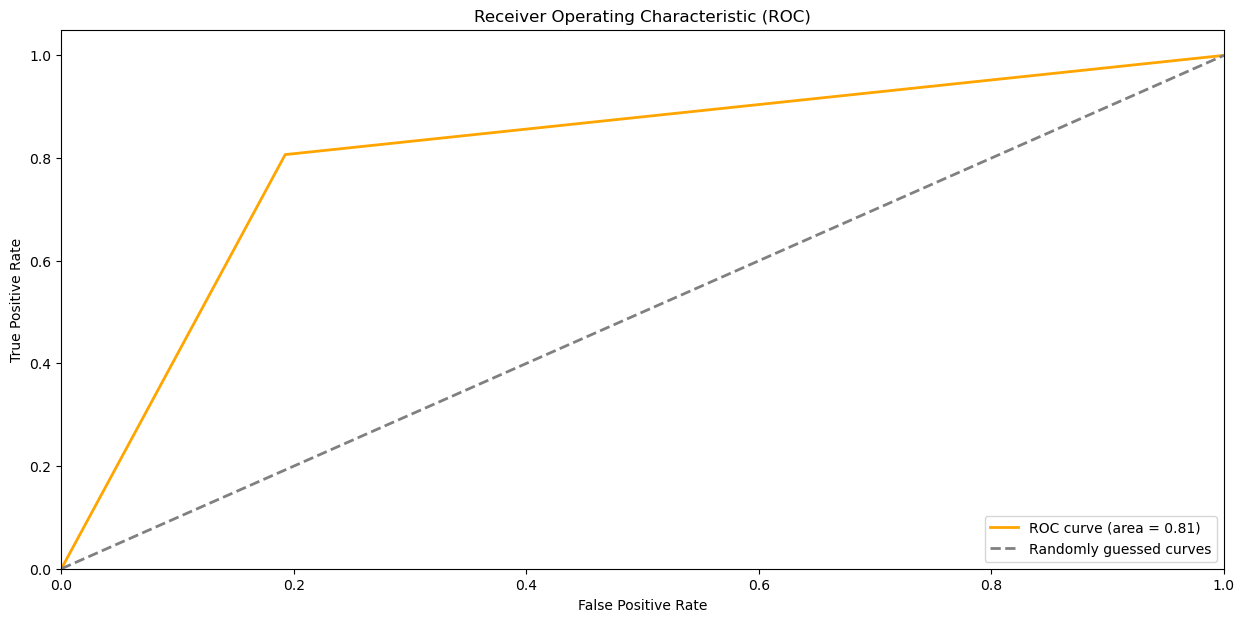

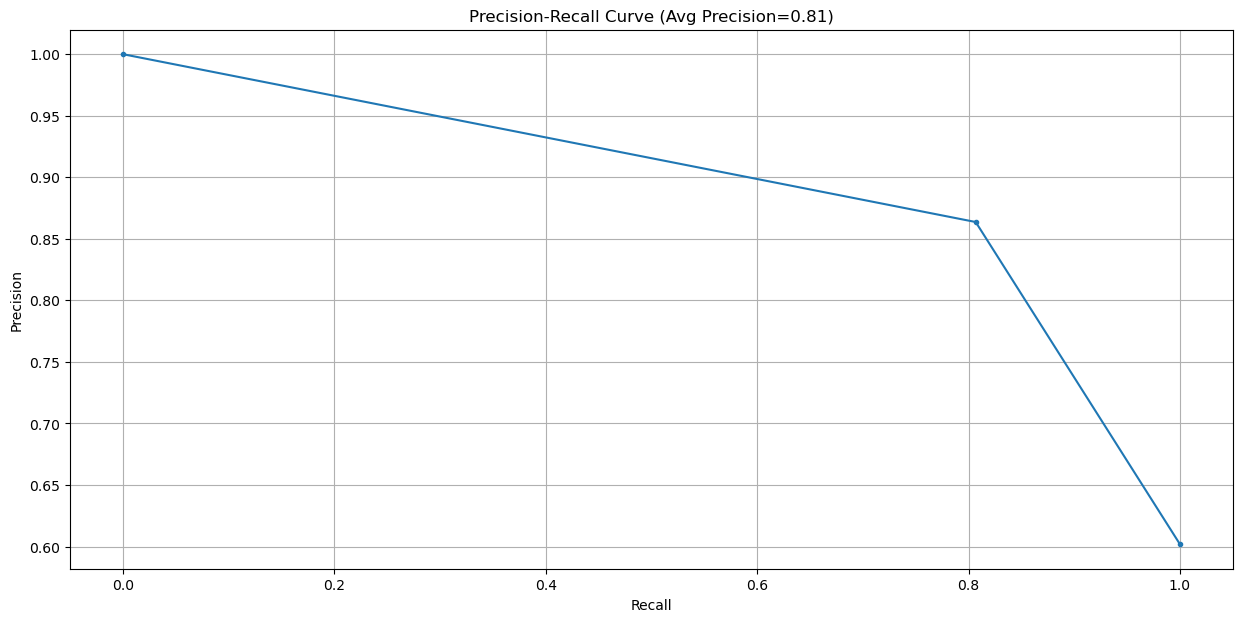

It's going down tomorrow


In [1]:
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, auc,accuracy_score
import talib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

#Smoothing index weighting，Call ewm to implement，Increase temporal relevance and reduce fallout
def expProcessing(df,alpha=0.9):
    data = df.ewm(alpha=alpha).mean()
    return data

# calculate technical analysis indicators and add to data
def featureExtensions(data):
    for x in [9, 14, 21, 30, 50, 90]:
        # Calculate RSI (Relative Strength Index)
        data['RSI_' + str(x)] = talib.RSI(data['Close'], timeperiod=x)
        # Calculate ROC (Rate of Change)
        data['ROC_' + str(x)] = talib.ROC(data['Close'], timeperiod=x)
        # Calculate Stochastic oscillator %D
        slowk, slowd = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=x, slowk_period=x, slowd_period=x)
        data['STOCH_SlowK_' + str(x)] = slowk
        data['STOCH_SlowD_' + str(x)] = slowd
        # Accumulation/Distribution
        data['ACCDIST_' + str(x)] = talib.AD(data['High'], data['Low'], data['Close'], data['Volume'])
        # On-balance Volume
        data['OBV_' + str(x)] = talib.OBV(data['Close'], data['Volume'])
        #Commodity Channel Index
        data['CCI_' + str(x)] = talib.CCI(data['High'], data['Low'], data['Close'], timeperiod=x)
        # Ease of Movement
        prev_high = data['High'].shift(1)
        prev_low = data['Low'].shift(1)
        eom = ((data['High'] + data['Low']) / 2 - (prev_high + prev_low) / 2) / (data['High'] - data['Low']) * data['Volume']
        data['EOM_' + str(x)] = eom
        # Trix
        data['TRIX_' + str(x)] = talib.TRIX(data['Close'], timeperiod=x)
#         # Vortex Indicator
#         data['Vortex_' + str(x)] = talib.VortexIndicator(data['High'], data['Low'], data['Close/Last'], timeperiod=x)
        # Momentum
        data['MOM_' + str(x)] = talib.MOM(data['Close'], timeperiod=x)
        # oney Flow Index and Ratio
        data['MFI_' + str(x)] = talib.MFI(data['High'], data['Low'], data['Close'], data['Volume'], timeperiod=x)
            # Add n-day exponential moving average to the data
        ema = talib.EMA(data['Close'], timeperiod=x)
        data['EMA_' + str(x)] = ema

    
   # add MACD to data
    macd, signal, _ = talib.MACD(data['Close'], fastperiod=14, slowperiod=50, signalperiod=9)
    data['MACD'] = macd
    data['MACD_Signal'] = signal
    
       
    #delete ''Volume' ,'Open', 'High','Low' to avoid data coupling
    del(data['Volume'])
    del(data['Open'])
    del(data['High'])
    del(data['Low'])
    del(data['Adj Close'])
    
    return data
#predict
def predict(df,n):
#     pred = (df.shift(-n)['Close/Last'].values >=df['Close/Last'].values).values
    pred = (df.shift(-n)['Close'].values >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)


# add pretiction column to data
def dataProcessing(df,horizon):
    data = featureExtensions(df).dropna().iloc[:-horizon]
    data['pred']= predict(data,n=horizon)
    # delete the close price to preventing predicted values from tracking to it
    del(data['Close'])
    return data.dropna()


spy_data = yf.download('SPY', start='1993-01-29', end='2023-08-01')
data = spy_data.shift().dropna()#delete NAN

#data added Smoothing index weighting
s_data = expProcessing(data)
s_data.head
dataset = dataProcessing(s_data,10)

# Except that the prediction columns are all treated as X
x = dataset[[x for x in dataset.columns if x not in ['pred']]]
y = dataset['pred']
Impact_length = 30


def dataset_generation_for_LSTM(x, pred, Impact_length, Split_ratio=0.7):
    pred_array = pred.values.reshape(-1, 1)
    data_length = len(pred_array)
    selected_data = x
    count_start = len(selected_data) - data_length
    temp = []

    for i in range(data_length):
        start_index = count_start - Impact_length
        end_index = count_start
        temp.append(selected_data[start_index:end_index].tolist())
        count_start += 1
    
    # Padding sequences to ensure they all have the same length
    max_length = max(len(seq) for seq in temp)
    padded_temp = [seq + [[0] * num_features] * (max_length - len(seq)) for seq in temp]
    
    Features = np.array(padded_temp)  # Convert to regular NumPy array
    Label = np.array(pred_array)
    
    x_train, x_test, y_train, y_test = train_test_split(
        Features, Label, test_size=1 - Split_ratio, random_state=500)
    
    return x_train, x_test, y_train, y_test

scaler = MinMaxScaler(feature_range=(-1, 1))
x = scaler.fit_transform(x)

# Get the number of features
num_features = x.shape[1]

x_train, x_test, y_train, y_test = dataset_generation_for_LSTM(x, y, Impact_length)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

input_dim = x_train.shape[2]
hidden_dim = 32
num_layer = 2
output_dim = 1
num_epochs = 100

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layer = num_layer
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layer, batch_first = True)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layer, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layer, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc1(out[:, -1, :])
        out = self.Sigmoid(out)
        return out
    
model = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, num_layer = num_layer, output_dim = output_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 


for i in range(num_epochs):
    y_train_prediction = model(x_train)
    loss = criterion(y_train_prediction, y_train)
#     print('Epoch=', i, 'BCELoss=', loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
y_test_prediction = torch.round(model(x_test))
prediction = torch.round(model(x_test)).detach().numpy()
report = classification_report(y_test, prediction, zero_division=1)

print (report)

y_test_prediction = model(x_test).detach().numpy()
y_test_prediction = np.round(y_test_prediction)  


fpr, tpr, thresholds = roc_curve(y_test, y_test_prediction)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

# Plotting the ROC curve
plt.figure(figsize=(15, 7))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, label='Randomly guessed curves',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()




from sklearn.metrics import precision_recall_curve, average_precision_score

# Generate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prediction)

# Calculate average precision score
avg_precision = average_precision_score(y_test, y_test_prediction)

# Plot precision-recall curve
plt.figure(figsize=(15, 7))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Avg Precision={:.2f})'.format(avg_precision))
plt.grid(True)
plt.show()

# result of comparison
# Sliced to make the view clearer
plt.figure(figsize=(15, 7))
plt.title('Forecasted trend VS Real trend')

# Select a specific range of values to compare
start_index = 100  # Adjust the start index as needed
end_index = 200    # Adjust the end index as needed

plt.plot(np.arange(start_index, end_index), prediction[start_index:end_index], alpha=0.7, label='Forecasted')
plt.plot(np.arange(start_index, end_index), y_test[start_index:end_index], alpha=0.7, label='Real')

plt.legend()
plt.show()

# Select a specific range of values to compare
plt.figure(figsize=(15,7))

y_test_prediction = model(x_test).detach().numpy()
posibility = np.round(y_test_prediction)   

# posibility = pipe.predict_proba(x_test)[:,1]
plt.title('Percentage of predicted results correct vs. actual value')

start_index = 600  # Adjust the start index as needed
end_index = 650    # Adjust the end index as needed

plt.plot(np.arange(start_index, end_index), posibility[start_index:end_index], alpha=0.7, label='Percentage of predicted results correct')
plt.plot(np.arange(start_index, end_index), y_test[start_index:end_index], alpha=0.7, label='Real')

plt.legend()
plt.show()

# predict tomorrow's stock trend (0 or 1)
t = prediction[-1]
if t == 1:
    print("It'll go up tomorrow")
else:
    print("It's going down tomorrow")

# SVC ( Trend Forcasting)

[*********************100%***********************]  1 of 1 completed
              precision    recall  f1-score   support

         0.0       0.55      0.64      0.59       878
         1.0       0.74      0.65      0.69      1340

    accuracy                           0.65      2218
   macro avg       0.64      0.65      0.64      2218
weighted avg       0.66      0.65      0.65      2218



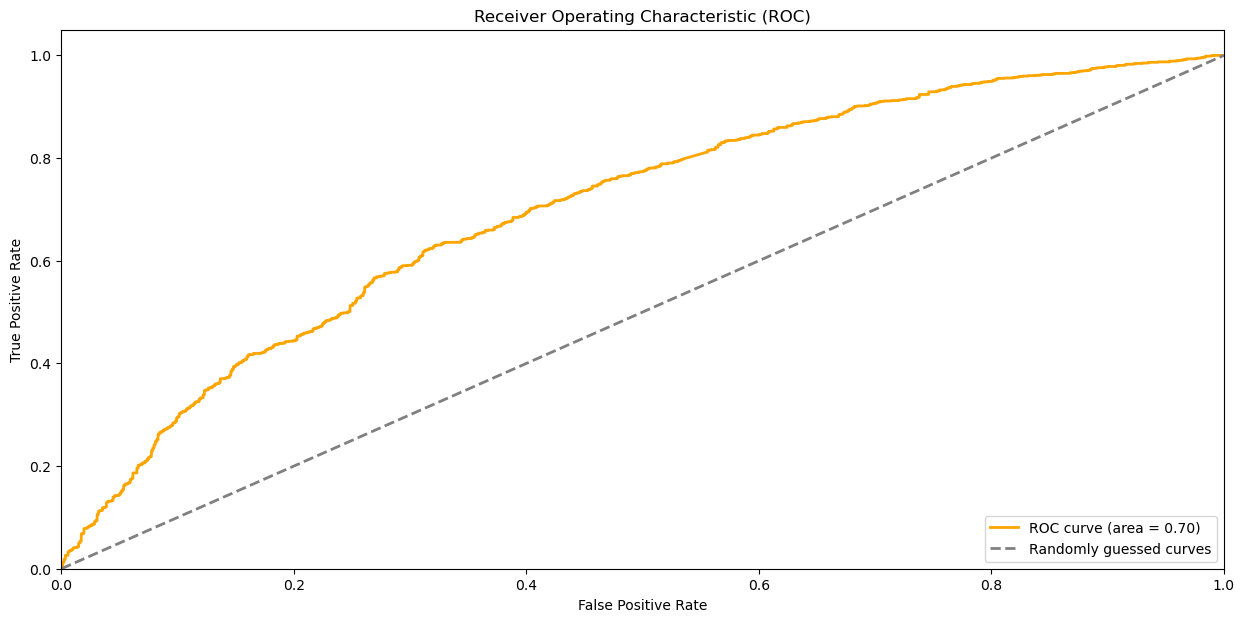

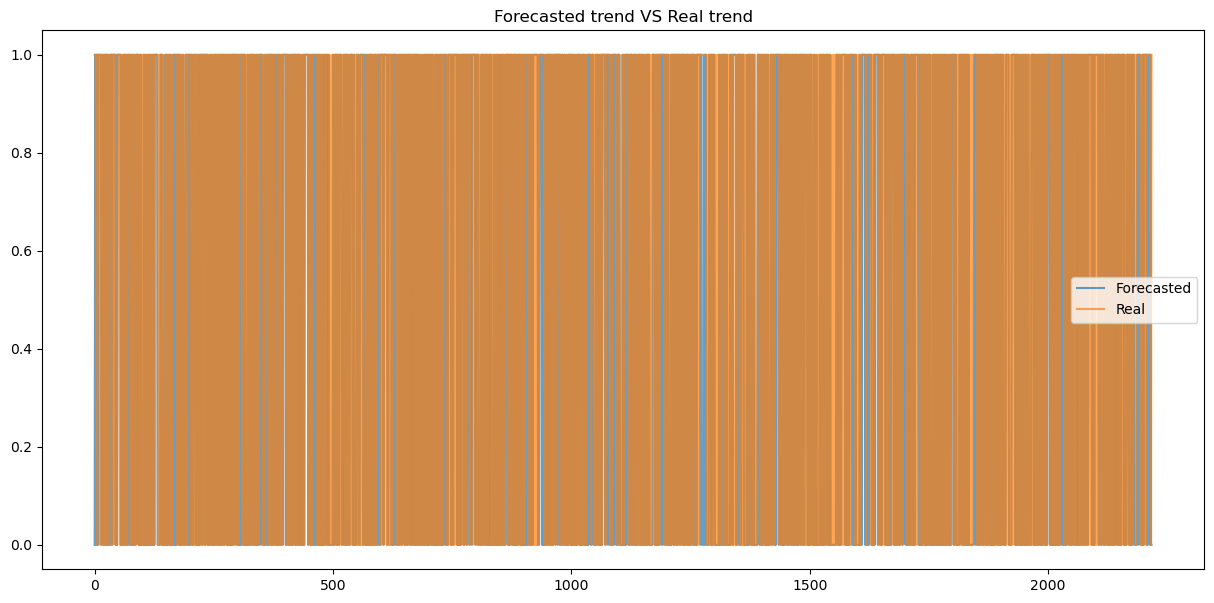

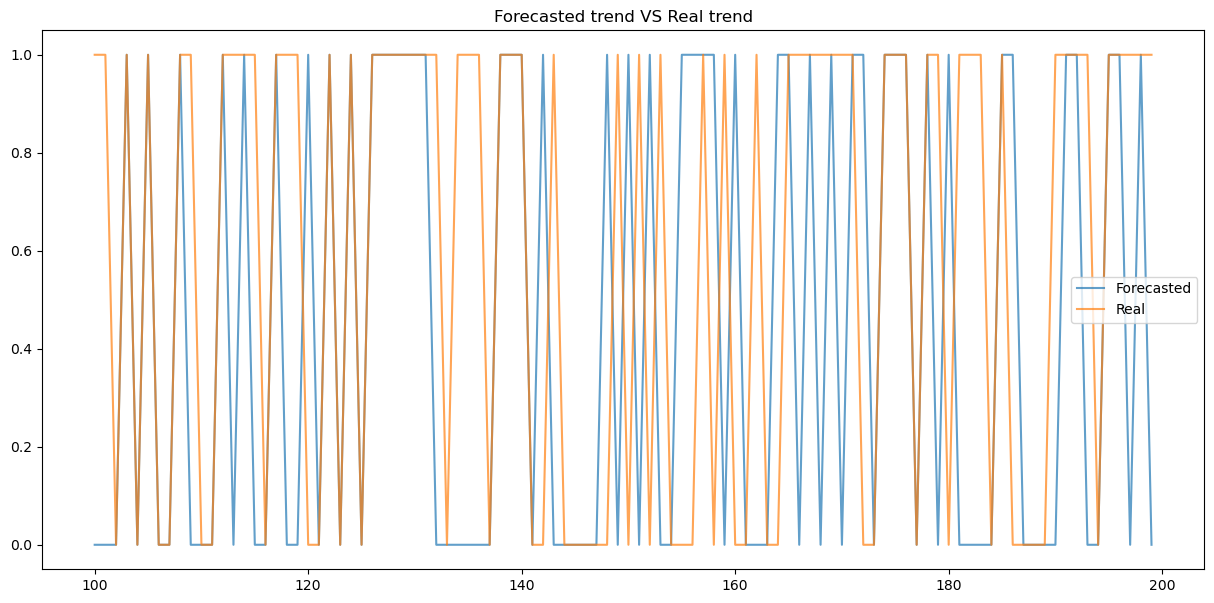

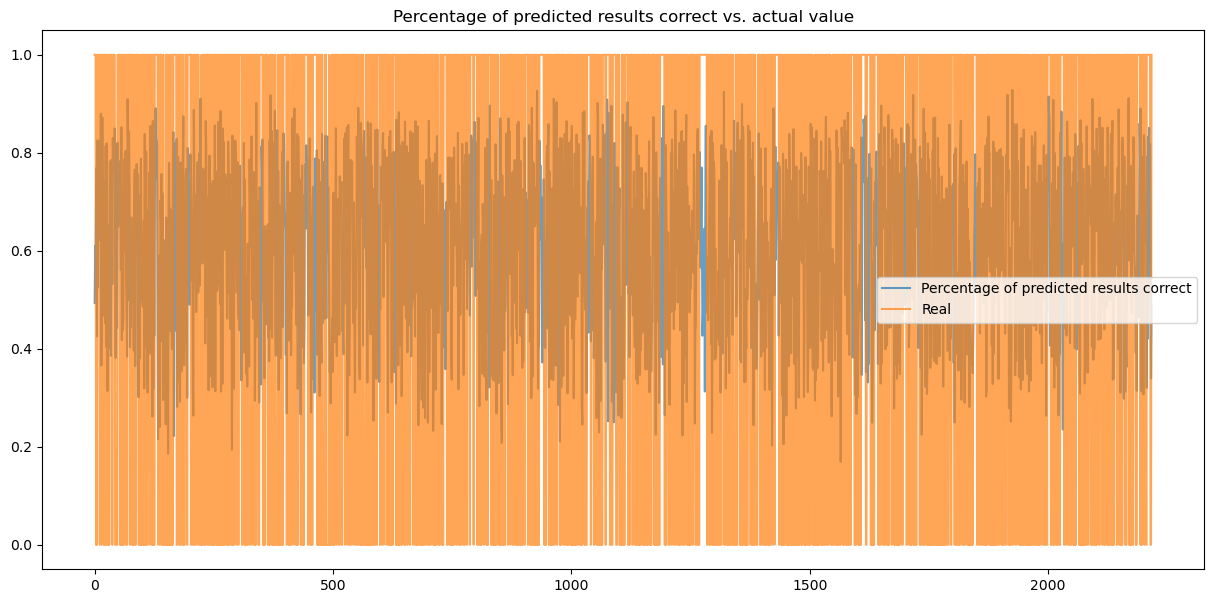

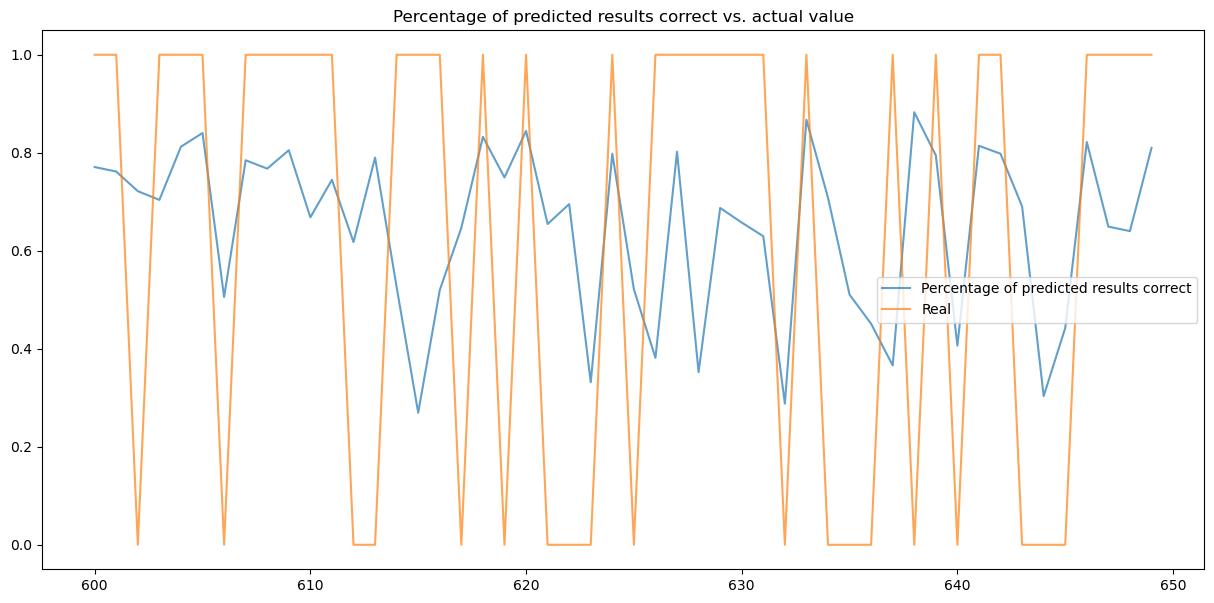

It's going down tomorrow


In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import talib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

spy_data = yf.download('SPY', start='1993-01-29', end='2023-08-01')
data = spy_data.shift().dropna()#delete NAN

#Smoothing index weighting，Call ewm to implement，Increase temporal relevance and reduce fallout
def expProcessing(df,alpha=0.9):
    data = df.ewm(alpha=alpha).mean()
    return data

#data added Smoothing index weighting
s_data = expProcessing(data)
s_data.head

# calculate technical analysis indicators and add to data
def featureExtensions(data):
    for x in [9, 14, 21, 30, 50, 90]:
        # Calculate RSI (Relative Strength Index)
        data['RSI_' + str(x)] = talib.RSI(data['Close'], timeperiod=x)
        # Calculate ROC (Rate of Change)
        data['ROC_' + str(x)] = talib.ROC(data['Close'], timeperiod=x)
        # Calculate Stochastic oscillator %D
        slowk, slowd = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=x, slowk_period=x, slowd_period=x)
        data['STOCH_SlowK_' + str(x)] = slowk
        data['STOCH_SlowD_' + str(x)] = slowd
        # Accumulation/Distribution
        data['ACCDIST_' + str(x)] = talib.AD(data['High'], data['Low'], data['Close'], data['Volume'])
        # On-balance Volume
        data['OBV_' + str(x)] = talib.OBV(data['Close'], data['Volume'])
        #Commodity Channel Index
        data['CCI_' + str(x)] = talib.CCI(data['High'], data['Low'], data['Close'], timeperiod=x)
        # Ease of Movement
        prev_high = data['High'].shift(1)
        prev_low = data['Low'].shift(1)
        eom = ((data['High'] + data['Low']) / 2 - (prev_high + prev_low) / 2) / (data['High'] - data['Low']) * data['Volume']
        data['EOM_' + str(x)] = eom
        # Trix
        data['TRIX_' + str(x)] = talib.TRIX(data['Close'], timeperiod=x)
#         # Vortex Indicator
#         data['Vortex_' + str(x)] = talib.VortexIndicator(data['High'], data['Low'], data['Close/Last'], timeperiod=x)
        # Momentum
        data['MOM_' + str(x)] = talib.MOM(data['Close'], timeperiod=x)
        # oney Flow Index and Ratio
        data['MFI_' + str(x)] = talib.MFI(data['High'], data['Low'], data['Close'], data['Volume'], timeperiod=x)
            # Add n-day exponential moving average to the data
        ema = talib.EMA(data['Close'], timeperiod=x)
        data['EMA_' + str(x)] = ema

    
   # add MACD to data
    macd, signal, _ = talib.MACD(data['Close'], fastperiod=14, slowperiod=50, signalperiod=9)
    data['MACD'] = macd
    data['MACD_Signal'] = signal
    
       
    #delete ''Volume' ,'Open', 'High','Low' to avoid data coupling
    del(data['Volume'])
    del(data['Open'])
    del(data['High'])
    del(data['Low'])
    del(data['Adj Close'])
    
    return data

#predict
def predict(df,n):
#     pred = (df.shift(-n)['Close/Last'].values >=df['Close/Last'].values).values
    pred = (df.shift(-n)['Close'].values >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)


# add pretiction column to data
def dataProcessing(df,horizon):
    data = featureExtensions(df).dropna().iloc[:-horizon]
    data['pred']= predict(data,n=horizon)
    # delete the close price to preventing predicted values from tracking to it
    del(data['Close'])
    return data.dropna()

dataset = dataProcessing(s_data,10)

# Except that the prediction columns are all treated as X
x = dataset[[x for x in dataset.columns if x not in ['pred']]]

y = dataset['pred']

SPLIT_RATIO = 0.7
x_train, x_test,y_train, y_test = train_test_split(x,y,train_size=SPLIT_RATIO)

pipe = Pipeline([('scl', StandardScaler()),
                 ('clf', SVC(cache_size = 5000,probability=True,class_weight='balanced'))]) 
#                      ('clf', SVC(C=1.0, gamma=444.83, cache_size = 5000,probability=True))])
pipe.fit(x_train,y_train.values.ravel())


from sklearn.metrics import classification_report, confusion_matrix
# Recorded predictions of price increases and decreases on the testing data
prediction = pipe.predict(x_test)

report=classification_report(y_test,prediction)
print (report)

# Probability values predicted by the model
probs = pipe.predict_proba(x_test)[:, 1]

# Calculate the points of the ROC curve
fpr, tpr, _ = roc_curve(y_test, probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(15, 7))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, label='Randomly guessed curves',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
# result of comparison
plt.figure(figsize=(15,7))
plt.title('Forecasted trend VS Real trend')
plt.plot(np.arange(len(prediction)),prediction,alpha=0.7,label='Forecasted')
plt.plot(np.arange(len(y_test)),y_test,alpha=0.7,label='Real')
plt.legend()

# result of comparison
# Sliced to make the view clearer
plt.figure(figsize=(15, 7))
plt.title('Forecasted trend VS Real trend')

# Select a specific range of values to compare
start_index = 100  # Adjust the start index as needed
end_index = 200    # Adjust the end index as needed

plt.plot(np.arange(start_index, end_index), prediction[start_index:end_index], alpha=0.7, label='Forecasted')
plt.plot(np.arange(start_index, end_index), y_test[start_index:end_index], alpha=0.7, label='Real')

plt.legend()
plt.show()

# chance of comparison
plt.figure(figsize=(15,7))
posibility = pipe.predict_proba(x_test)[:,1]
plt.title('Percentage of predicted results correct vs. actual value')
plt.plot(np.arange(len(posibility)),posibility,alpha=0.7,label='Percentage of predicted results correct')
plt.plot(np.arange(len(y_test)),y_test,alpha=0.7,label='Real')

plt.legend()
plt.show()

# Select a specific range of values to compare
plt.figure(figsize=(15,7))
posibility = pipe.predict_proba(x_test)[:,1]
plt.title('Percentage of predicted results correct vs. actual value')

start_index = 600  # Adjust the start index as needed
end_index = 650    # Adjust the end index as needed

plt.plot(np.arange(start_index, end_index), posibility[start_index:end_index], alpha=0.7, label='Percentage of predicted results correct')
plt.plot(np.arange(start_index, end_index), y_test[start_index:end_index], alpha=0.7, label='Real')

plt.legend()
plt.show()

# predict tomorrow's stock trend 
t = prediction[-1]
if t == 1:
    print("It'll go up tomorrow")
else:
    print("It's going down tomorrow")